### Setup

In [370]:
import json
import time
from functools import reduce

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.autonotebook import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')

from py2neo import Graph, Node, Relationship

In [371]:
public_address = '54.174.175.98'
graph = Graph('bolt://{}:7687'.format(public_address), auth=('neo4j','myneo'))

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False, verbose=True):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    if verbose:
        print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

### Pull data

In [566]:
min_year, max_year = 1900, 2020
years_ahead = 5;

query = """
MATCH (q:Quanta)-[:PUBLISHED_IN]->(y:Year)
WHERE y.year>{miny} AND y.year < {maxy}-{ya}
MATCH (q)-[m0:METRICS_IN]->(:Year {{year:y.year}})
MATCH (q)-[m1:METRICS_IN]->(:Year {{year:y.year+1}})
MATCH (q)-[m{ya}:METRICS_IN]->(:Year {{year:y.year+{ya}}})
WHERE m0.node2vec is not null
WITH q, y, m0, m1, m{ya}
RETURN 
    id(q) AS id, 
    y.year AS year, 
    coalesce(m0.adopters,0) AS adopters_0,
    coalesce(m0.timeScaledPageRank, 0) AS timeScaledPageRank_0,
    coalesce(m0.citations, 0) as citations_0,
    coalesce(m0.node2vec, 0) AS node2vec_0,
    coalesce(m1.adopters,0) AS adopters_1,
    coalesce(m1.timeScaledPageRank, 0) AS timeScaledPageRank_1,
    coalesce(m1.citations, 0) as citations_1,
    coalesce(m1.node2vec, 0) AS node2vec_1,
    coalesce(m{ya}.timeScaledPageRank, 0) as timeScaledPageRank_{ya},
    coalesce(m{ya}.citations, 0) as citations_{ya}
""".format(miny=min_year, maxy=max_year, ya=years_ahead)
data = run_query(query, graph, to_df=True)

Query completed in 9.78 minutes.


In [ ]:
n2vdims = len(data.loc[0,'node2vec_0'])

df = pd.concat([data, data.loc[:,'node2vec_0'].apply(pd.Series)], axis=1) \
        .rename(columns=dict(zip(range(n2vdims), 
                                 ["node2vec_0_{}".format(i) for i in range(n2vdims)])))
df = pd.concat([df, data.loc[:,'node2vec_1'].apply(pd.Series)], axis=1) \
        .rename(columns=dict(zip(range(n2vdims), 
                                 ["node2vec_1_{}".format(i) for i in range(n2vdims)])))

df = df.drop(['node2vec_0', 'node2vec_1'], axis=1)
df = df.dropna()

df.describe()

In [ ]:
sns.countplot(data=df.loc[, y='year')

In [ ]:
pctile = .95
df['is_high_impact'] = df['timeScaledPageRank_5'] > df['timeScaledPageRank_5'].quantile(q=pctile)

print(df['is_high_impact'].value_counts())
count_class_0, count_class_1 = df['is_high_impact'].value_counts()
df_class_0 = df[df['is_high_impact'] == 0]
df_class_1 = df[df['is_high_impact'] == 1]
if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df = pd.concat([df_class_1_under, df_class_0], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df = pd.concat([df_class_1, df_class_0_under], axis=0)
print(df['is_high_impact'].value_counts())

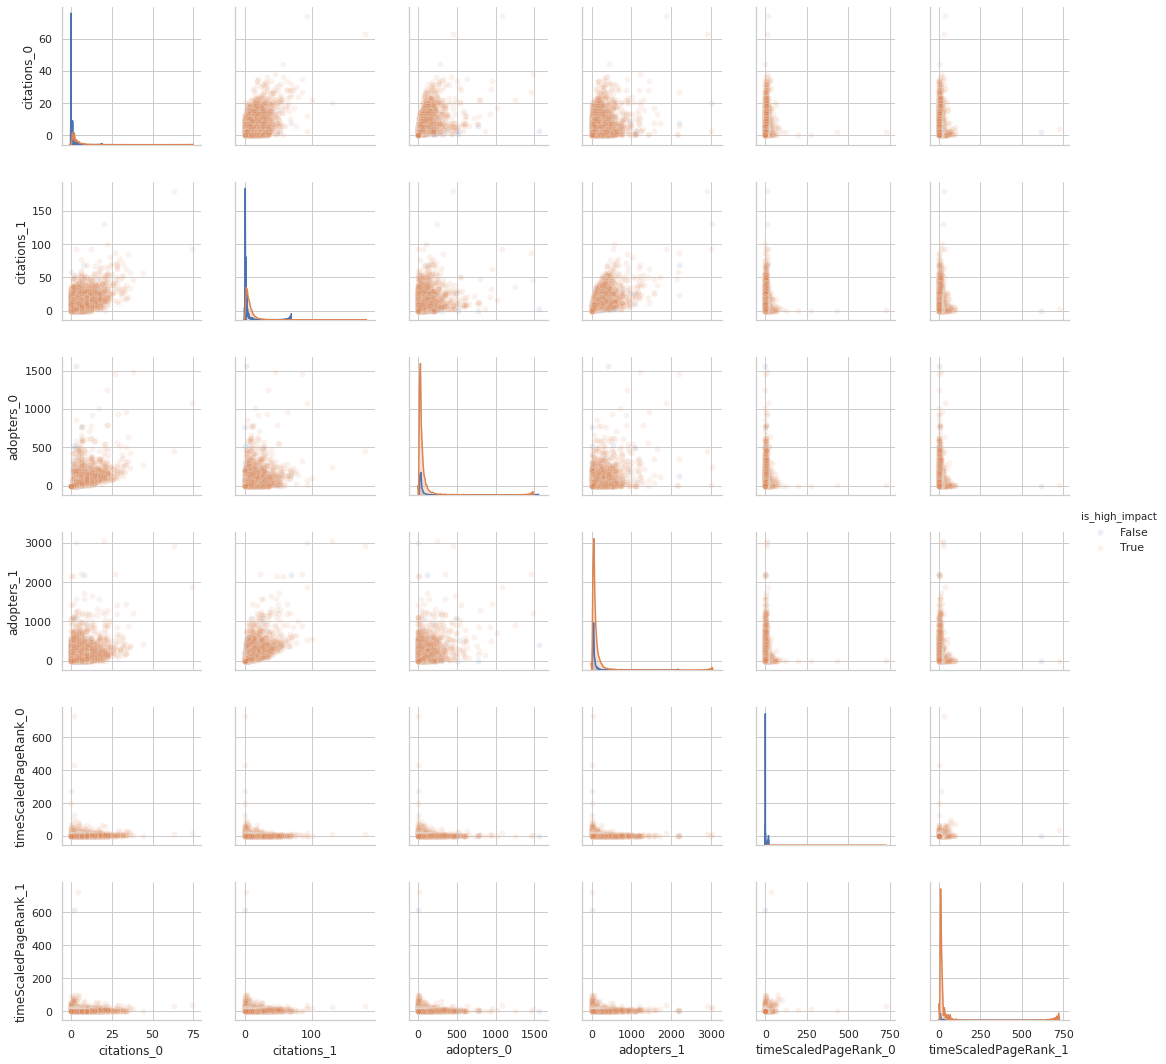

In [492]:
cols_to_plot=['citations_0', 'citations_1', 'citations_5' 
              'adopters_0', 'adopters_1', 
              'timeScaledPageRank_0', 'timeScaledPageRank_1', 'timeScaledPageRank_5'
                 ]

g = sns.pairplot(df,
                 y_vars=cols_to_plot, 
                 x_vars=cols_to_plot,
                 hue='is_high_impact', 
                 plot_kws=dict(s=35, alpha=0.1))

### Predictions

In [563]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
columns_to_keep = df.columns.drop('is_high_impact').drop('id') \
    .drop('timeScaledPageRank_5').drop('citations_5').drop('year')

X = df.loc[:, columns_to_keep]
y = df.loc[:,'is_high_impact']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75)

test_inds = X_test.index

In [564]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

df.drop(columns='dt_predicted')
df.loc[test_inds, 'dt_predicted'] = y_pred
df.loc[test_inds, 'decisiontree_classification_accuracy'] = 
    (results['is_high_impact'] == results['dt_predicted']).astype(int)

print("Clasificationa accuracy: {}".format(clf.score(X_test, y_test)))
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

KeyError: 'dt_predicted'

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

df.drop(columns='lr_predicted')
df.loc[test_inds, 'lr_predicted'] = y_pred
df.loc[test_inds, 'logistic_regression_classification_accuracy'] = 
    (results['is_high_impact'] == results['dt_predicted']).astype(int)

print("Clasificationa accuracy: {}".format(clf.score(X_test, y_test)))
print("F1 Score: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

feature_importance = pd.DataFrame.from_dict(
    dict(zip(X.columns, clf.feature_importances_)), orient='index').T
sns.barplot(orient='h',data=feature_importance)

In [546]:
sns.lineplot(x='year', y='decision_treeclassification_accuracy',
             data=df.loc[test_inds,:], 
             dashes=False, markers=True)

KeyError: 'dt_predicted'

In [ ]:
tpot = TPOTClassifier(verbosity=2)
tpot.fit(X_train, y_train)

In [ ]:
tpot.score(X_test, y_test)

In [ ]:
tpot.export('tpot_exported_pipeline.py')